In [69]:
import struct
import sys
import serial
import binascii
import time
import numpy as np
import math

import os
import datetime
import matplotlib.pyplot as plt

# Local File Imports
from parse_bin_output import *

# specify the binary file path below

import os
import time


#monitor_directory(path)

processing file: ../Industrial_Visualizer/binData/12_04_2023_23_18_30/pHistBytes_1.bin
Motion is detected at Frame26at distance 0.6893382352941176 with height 1.6406617647058823
Motion is detected at Frame42at distance 0.4136029411764706 with height 1.9163970588235295
{26: 1.6406617647058823, 42: 1.9163970588235295}


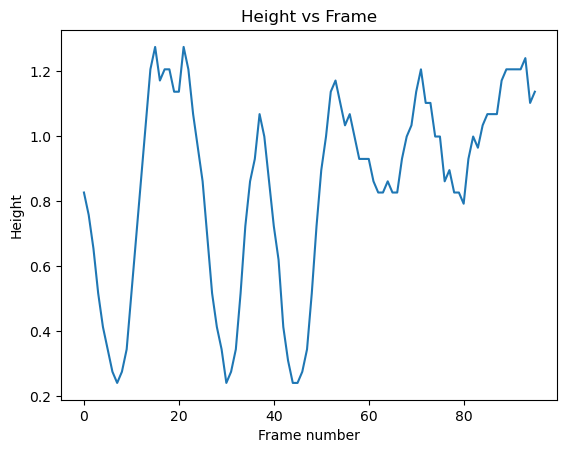

In [70]:
import scipy.signal as signal
path2 = "../Industrial_Visualizer/binData/12_04_2023_23_18_30"
output_dict = parse_ADC(path2)

#Find distances
door_height = 2.33

frame_num = 0
range_profile = output_dict[frame_num]['rangeProfile']
#plotting range profile

# define parameters to determine the range:
nFFT = len(range_profile)     # number of FFT bins
fs = 100e6 / 8                  # sampling frequency
c0 = 3e8                        # speed of light
S = 170e12                      # slope of chirp signal
sam_perd = 1/fs
num_ADC = 256
chirp_dur = sam_perd*num_ADC
bandwidth = S*chirp_dur
Dres = c0/(2*bandwidth)

dmax=(fs*c0)/(2*S)
delta_d=dmax/nFFT
# vRange represents the distance vector that will be shown in the x axes of the plot before
vRange = np.arange(nFFT) * delta_d
vRange = vRange[:len(range_profile)]

def get_distances(output_dict):
  distances = []
  for i in range(len(output_dict)):
    frame = output_dict[i]
    range_profile = frame['rangeProfile']

    peaks, _ = signal.find_peaks(range_profile, height=np.max(range_profile) * .05)
    
    if len(peaks) > 0:
        closest_peak = peaks[np.argmin(peaks)]
        # calculate distance
        vRange = np.arange(nFFT) * delta_d
        distances.append(vRange[closest_peak])

  return distances

def smooth_data(data, window_size):
  moving_avg = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
  return moving_avg

def find_heights(smoothed_data):
  highestFrame = 0
  threshold = .1477
  heights = {}
  for i in range(1, len(smoothed_data)):
    displacement = smoothed_data[i - 1] - smoothed_data[i]
    if displacement > threshold :
      if (i > highestFrame and i > (highestFrame + 1)):
        highestFrame = i
        heights[i] = door_height - smoothed_data[i]
        print("Motion is detected at Frame" + str(i) + "at distance " + str(smoothed_data[i]) + " with height " + str(door_height - smoothed_data[i]))
  return heights

plt.figure()
data = smooth_data(get_distances(output_dict), 5)
temp_dict = find_heights(data)
print(temp_dict)
plt.plot(data)
plt.xlabel('Frame number')
plt.ylabel('Height')
plt.title('Height vs Frame')
plt.show()



In [71]:
from kmeans import *
# import required libraries
import struct
import sys
import serial
import binascii
import time
import numpy as np
import math

import os
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from IPython.display import clear_output

def process_points(output_dict):
  # specify the number of clusters
    k = 2
    # specify the number of frames
    num_frames = len(output_dict)
    points = []
    for target_frame in range(num_frames):
        if 'pointCloud' in output_dict[target_frame].keys():
            xyz = output_dict[target_frame]['pointCloud'][:, 0:3]

            # xyz coordinate of detected points
            x = xyz[:, 0]
            y = xyz[:, 1]
            z = xyz[:, 2]

            kmeans = KMeans(n_clusters=1, random_state=0, n_init=10).fit(xyz)
            centroids = kmeans.cluster_centers_
                
            # Plot the point cloud
            if len(centroids[:, 0]) > 0:
                points.append(centroids[:, 0][0])
    return points

smoothed_points = smooth_data(process_points(output_dict), 10)

print(smoothed_points)
plt.plot(smoothed_points)
plt.title('Array Plot')
plt.xlabel('Frame Num')
plt.ylabel('X-axis')
plt.grid(True)
plt.show()


        

# for i, centroid_trajectory in enumerate(centroids_data):
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     centroid_trajectory = np.array(centroid_trajectory)

#     ax.scatter(centroid_trajectory[:, 0], centroid_trajectory[:, 1], centroid_trajectory[:, 2], label=f'Centroid {i+1} trajectory')
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
#     ax.legend()
#     plt.show()

In [ ]:
import tkinter as tk



#Mointor Dictionary 
def process_new_bin_data(path):
  #1 - get output dict 
  output_dict = parse_ADC(path)

  #2 - get height information









def monitor_directory(path):
  before = dict([(f, None) for f in os.listdir(path)])
  while True:
    time.sleep(1)
    after = dict([(f, None) for f in os.listdir(path)])
    added = [f for f in after if not f in before]
    if added:
      return process_new_bin_data(path+"/"+added[0])
    before = after

path = "../Industrial_Visualizer/binData"
